In [1]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem

import torch
from torch import nn
import torch.nn.functional as F

import sys
sys.path.append('src/')

from smiles_lstm.model.smiles_vocabulary import SMILESTokenizer, Vocabulary, create_vocabulary

from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
# ignore some deprecation warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Functions

In [2]:
def pad_sequence(tokenizer_array, desired_length):
    padded_sequence = pad_sequences([tokenizer_array], maxlen=desired_length, padding='post')[0]
    return padded_sequence

def preprocess_smiles_data(x):
    x = tk.tokenize(x, with_begin_and_end=False)
    x = vocabulary.encode(x )
    x  = pad_sequence(x, 160 )
    x  = torch.tensor([x ])
    
    return X

def canonicalize_smiles(smiles):
    '''This function takes a non-canonical SMILES and
    returns the canonical version'''
    mol = Chem.MolFromSmiles(smiles) #create a mol object from input smiles 
    canonical_smiles = Chem.MolToSmiles(mol) #convert the previous mol object to SMILES using Chem.MolToSmiles()
    return canonical_smiles

## Load main data set

In [3]:
df = pd.read_csv('retrosynthesis-all', header=None)
df['source'] = df[0].apply(lambda x: x.split('>>')[0])
df['target'] = df[0].apply(lambda x: x.split('>>')[1])
df['source'] = df['source'].apply(lambda x: canonicalize_smiles(x))
df['target'] = df['target'].apply(lambda x: canonicalize_smiles(x))
df.drop(0, axis=1, inplace=True)
# Remove spaces from all columns
for col in df.columns: df[col] = df[col].str.replace(' ', '')

## Define `Tokenizer` and `Vocabulary`

In [4]:
class Dataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset that takes a file containing \n separated SMILES.
    """

    def __init__(self, smiles_list : list, vocabulary : Vocabulary,
                 tokenizer : SMILESTokenizer) -> None:
        self._vocabulary  = vocabulary
        self._tokenizer   = tokenizer
        self._smiles_list = list(smiles_list)

    def __getitem__(self, i : int) -> torch.Tensor:
        smi     = self._smiles_list[i]
        tokens  = self._tokenizer.tokenize(smi, with_begin_and_end=False)
        encoded = self._vocabulary.encode(tokens)
        encoded = pad_sequence(encoded, 200)
        return torch.tensor(encoded.astype(int), dtype=torch.long)  # pylint: disable=E1102

    def __len__(self) -> int:
        return len(self._smiles_list)

    @staticmethod
    def collate_fn(encoded_seqs : list) -> torch.Tensor:
        """
        Converts a list of encoded sequences into a padded tensor.
        """
        max_length   = max([seq.size(0) for seq in encoded_seqs])
        collated_arr = torch.zeros(len(encoded_seqs),
                                   max_length,
                                   dtype=torch.long)  # padded with zeros
        for i, seq in enumerate(encoded_seqs):
            collated_arr[i, :seq.size(0)] = seq
        return collated_arr

    def pad_sequence(tokenizer_array, desired_length):
        padded_sequence = pad_sequences([tokenizer_array], maxlen=desired_length, padding='post')[0]
        return padded_sequence


In [5]:
# create a vocabulary using all SMILES in df
dataset = df['source'].unique().tolist() + df['target'].unique().tolist()
dataset = np.unique(dataset).tolist()

tokenizer = SMILESTokenizer()
vocabulary   = create_vocabulary(smiles_list=dataset, tokenizer=tokenizer, canonical=True)

print(f'There are {len(vocabulary)} unique tokens in the vocabulary.\n')

# train_dataset = Dataset(smiles_list=df['source'].tolist(), vocabulary=vocabulary, tokenizer=tokenizer)
# train_dataset = train_dataset.collate_fn(train_dataset)

There are 85 unique tokens in the vocabulary.



## Train / validation / test split

In [6]:
from sklearn.model_selection import train_test_split

print('Original dataset:')
print(df.shape)

# Splitting the data into train and combined val/test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Printing the sizes of the resulting splits
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

train     = train_data.copy()
test      = test_data.copy()

# train = train[:2000]
# test = test[:500]

train_X = Dataset(smiles_list=train['source'].tolist(), vocabulary=vocabulary, tokenizer=tokenizer)
train_X = train_X.collate_fn(train_X)
train_y = Dataset(smiles_list=train['target'].tolist(), vocabulary=vocabulary, tokenizer=tokenizer)
train_y = train_y.collate_fn(train_y)

test_X = Dataset(smiles_list=test['source'].tolist(), vocabulary=vocabulary, tokenizer=tokenizer)
test_X = test_X.collate_fn(test_X)
test_y = Dataset(smiles_list=test['target'].tolist(), vocabulary=vocabulary, tokenizer=tokenizer)
test_y = test_y.collate_fn(test_y)

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

Original dataset:
(45033, 2)
Train data size: 36026
Test data size: 9007


torch.Size([36026, 200]) torch.Size([36026, 200])
torch.Size([9007, 200]) torch.Size([9007, 200])


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2SeqLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout=.2)
        self.fc = nn.Linear(hidden_size, output_size, dropout=.2)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        output, _ = self.lstm(embedded)
        output, _ = self.lstm(output)
        output = self.fc(output)
        # softmax to apply on dimension 1, i.e. per row
        logits = self.logsoftmax(output)
        return logits

# Set hyperparameters
input_size = len(vocabulary)  # Replace with the actual vocabulary size of your input data
hidden_size = 512  # Adjust the hidden size according to your needs
output_size = len(vocabulary)  # Replace with the actual vocabulary size of your output data
learning_rate = 0.0001
num_epochs = 10
batch_size = 1024

# Create the model
model = Seq2SeqLSTM(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss(reduce=None)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Before the training loop
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0
    model.train()
    for i in tqdm(range(0, len(train_X), batch_size)):
        # Prepare batch
        batch_X = train_X[i:i+batch_size].to(device)
        batch_y = train_y[i:i+batch_size].to(device)

        # Forward pass
        optimizer.zero_grad()
        output = model(batch_X)

        # Compute loss
        loss = criterion(output.view(-1, output_size), batch_y.view(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    # Validation
    model.eval()
    val_loss = 0
    val_batches = 0
    with torch.no_grad():
        for j in range(0, len(test_X), batch_size):
            val_batch_X = test_X[j:j+batch_size].to(device)
            val_batch_y = test_y[j:j+batch_size].to(device)
            
            val_output = model(val_batch_X)
            val_loss += criterion(val_output.view(-1, output_size), val_batch_y.view(-1)).item()
            val_batches += 1

    # Print average loss for the epoch
    average_loss = total_loss / num_batches
    average_val_loss = val_loss / val_batches

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}")

    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")
    train_losses.append(average_loss)
    val_losses.append(average_val_loss)

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:05<00:00,  6.58it/s]


Epoch 1/10, Loss: 5.0853, Val Loss: 4.9608


100%|██████████| 36/36 [00:05<00:00,  6.61it/s]


Epoch 2/10, Loss: 4.9147, Val Loss: 4.8741


100%|██████████| 36/36 [00:05<00:00,  6.61it/s]


Epoch 3/10, Loss: 4.8593, Val Loss: 4.8382


100%|██████████| 36/36 [00:05<00:00,  6.62it/s]


Epoch 4/10, Loss: 4.8329, Val Loss: 4.8215


100%|██████████| 36/36 [00:05<00:00,  6.61it/s]


Epoch 5/10, Loss: 4.8187, Val Loss: 4.8145


100%|██████████| 36/36 [00:05<00:00,  6.61it/s]


Epoch 6/10, Loss: 4.8092, Val Loss: 4.8022


100%|██████████| 36/36 [00:05<00:00,  6.61it/s]


Epoch 7/10, Loss: 4.7996, Val Loss: 4.7944


100%|██████████| 36/36 [00:05<00:00,  6.61it/s]


Epoch 8/10, Loss: 4.7922, Val Loss: 4.7877


100%|██████████| 36/36 [00:05<00:00,  6.61it/s]


Epoch 9/10, Loss: 4.7864, Val Loss: 4.7832


100%|██████████| 36/36 [00:05<00:00,  6.61it/s]


Epoch 10/10, Loss: 4.7824, Val Loss: 4.7800


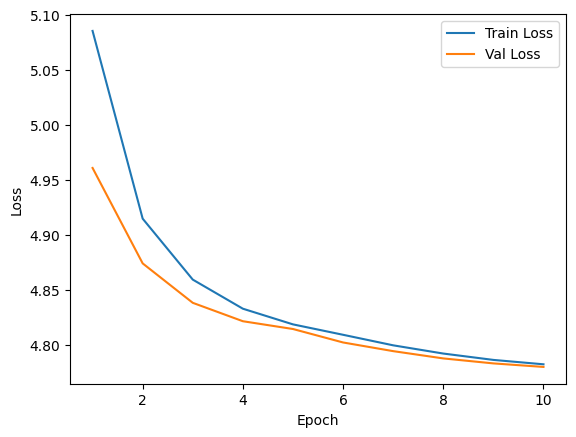

In [9]:
import matplotlib.pyplot as plt

# Plot learning curve
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
model.eval()
print('Predictions:')
y_pred = model(test_X[142].to(device)).argmax(dim=1).flatten()
print(tokenizer.untokenize(vocabulary.decode(y_pred.cpu().numpy())))

print('Real:')
y = test_y[142].to(device)
print(tokenizer.untokenize(vocabulary.decode(y.cpu().numpy())))

print('Input:')
x = test_X[142]
print(tokenizer.untokenize(vocabulary.decode(x.cpu().numpy())))

Predictions:
Cc1c5(CC(=O)N2CCN(5(=O)(=O)c)ccccc3)(=O)))C(=O)C2C)c(=O))c1=O
Real:
CC1NCCN(S(=O)(=O)c2ccccc2[N+](=O)[O-])C1=O.Cc1cn(CC(=O)O)c(=O)[nH]c1=O
Input:
Cc1cn(CC(=O)N2CCN(S(=O)(=O)c3ccccc3[N+](=O)[O-])C(=O)C2C)c(=O)[nH]c1=O


In [12]:
x = 'C00082'
y = 'C00811'

cpds = pd.read_csv('../data/compounds_final.csv', index_col=0)
x = cpds[cpds['Entry'] == x]['SMILES'].values[0]
y = cpds[cpds['Entry'] == y]['SMILES'].values[0]
print(x, '\n' ,y)

x = tokenizer.tokenize(x, with_begin_and_end=False)
x =vocabulary.encode(x)
x = pad_sequence(x, 158)
x = torch.tensor(x.astype(int), dtype=torch.long)  

y = tokenizer.tokenize(y, with_begin_and_end=False)
y =vocabulary.encode(y)
y = pad_sequence(y, 158)
y = torch.tensor(y.astype(int), dtype=torch.long)  

y_pred = model(x.to(device)).argmax(dim=1).flatten()
y_pred

N[C@@H](Cc1ccc(O)cc1)C(=O)O 
 O=C(O)/C=C/c1ccc(O)cc1


tensor([24, 24,  3, 20, 81,  8, 81, 81, 81,  3, 25,  4, 81, 81,  8,  4, 20,  3,
        17, 25,  4, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0')

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

# reverse back to SMILES
s = tokenizer.untokenize(vocabulary.decode(x.cpu().numpy()))
s1 = tokenizer.untokenize(vocabulary.decode(y.cpu().numpy()))
s2 = tokenizer.untokenize(vocabulary.decode(y_pred.cpu().numpy()))

print(s)
print(s1)
print(s2)

# Convert SMILES strings to RDKit molecules
mol1 = Chem.MolFromSmiles(s1)
mol2 = Chem.MolFromSmiles(s2)

# Generate Morgan fingerprints
fp1 = AllChem.GetMorganFingerprint(mol1, 2)  # 2 is the radius of the fingerprint
fp2 = AllChem.GetMorganFingerprint(mol2, 2)

# Calculate Tanimoto similarity
tanimoto = DataStructs.TanimotoSimilarity(fp1, fp2)

print("Tanimoto similarity:", tanimoto)

N[C@@H](Cc1ccc(O)cc1)C(=O)O
O=C(O)/C=C/c1ccc(O)cc1
NN(Cc1ccc(O)cc1)C(=O)O
Tanimoto similarity: 0.5909090909090909


In [ ]:
1/0